# Problem Statement

## **Business Context**

"Visit with Us," a leading travel company, is revolutionizing the tourism industry by leveraging data-driven strategies to optimize operations and customer engagement. While introducing a new package offering, such as the Wellness Tourism Package, the company faces challenges in targeting the right customers efficiently. The manual approach to identifying potential customers is inconsistent, time-consuming, and prone to errors, leading to missed opportunities and suboptimal campaign performance.

To address these issues, the company aims to implement a scalable and automated system that integrates customer data, predicts potential buyers, and enhances decision-making for marketing strategies. By utilizing an MLOps pipeline, the company seeks to achieve seamless integration of data preprocessing, model development, deployment, and CI/CD practices for continuous improvement. This system will ensure efficient targeting of customers, timely updates to the predictive model, and adaptation to evolving customer behaviors, ultimately driving growth and customer satisfaction.


## **Objective**

As an MLOps Engineer at "Visit with Us," your responsibility is to design and deploy an MLOps pipeline on GitHub to automate the end-to-end workflow for predicting customer purchases. The primary objective is to build a model that predicts whether a customer will purchase the newly introduced Wellness Tourism Package before contacting them. The pipeline will include data cleaning, preprocessing, transformation, model building, training, evaluation, and deployment, ensuring consistent performance and scalability. By leveraging GitHub Actions for CI/CD integration, the system will enable automated updates, streamline model deployment, and improve operational efficiency. This robust predictive solution will empower policymakers to make data-driven decisions, enhance marketing strategies, and effectively target potential customers, thereby driving customer acquisition and business growth.

## **Data Description**

The dataset contains customer and interaction data that serve as key attributes for predicting the likelihood of purchasing the Wellness Tourism Package. The detailed attributes are:

**Customer Details**
- **CustomerID:** Unique identifier for each customer.
- **ProdTaken:** Target variable indicating whether the customer has purchased a package (0: No, 1: Yes).
- **Age:** Age of the customer.
- **TypeofContact:** The method by which the customer was contacted (Company Invited or Self Inquiry).
- **CityTier:** The city category based on development, population, and living standards (Tier 1 > Tier 2 > Tier 3).
- **Occupation:** Customer's occupation (e.g., Salaried, Freelancer).
- **Gender:** Gender of the customer (Male, Female).
- **NumberOfPersonVisiting:** Total number of people accompanying the customer on the trip.
- **PreferredPropertyStar:** Preferred hotel rating by the customer.
- **MaritalStatus:** Marital status of the customer (Single, Married, Divorced).
- **NumberOfTrips:** Average number of trips the customer takes annually.
- **Passport:** Whether the customer holds a valid passport (0: No, 1: Yes).
- **OwnCar:** Whether the customer owns a car (0: No, 1: Yes).
- **NumberOfChildrenVisiting:** Number of children below age 5 accompanying the customer.
- **Designation:** Customer's designation in their current organization.
- **MonthlyIncome:** Gross monthly income of the customer.

**Customer Interaction Data**
- **PitchSatisfactionScore:** Score indicating the customer's satisfaction with the sales pitch.
- **ProductPitched:** The type of product pitched to the customer.
- **NumberOfFollowups:** Total number of follow-ups by the salesperson after the sales pitch.-
- **DurationOfPitch:** Duration of the sales pitch delivered to the customer.


# Model Building

## Data Registration

*   Imports Libraries: It brings in the necessary tools for working with the Hugging Face Hub.

*   Sets Up Repository Information: It defines where the dataset will be stored, including a placeholder for the user ID and dataset name.

*   Initializes the API Client: It sets up a connection to the Hugging Face Hub using an authentication token stored in your environment.

*   Checks for Existing Repository: It looks for an existing dataset repository. If it finds one, it informs you.

*   Creates a New Repository: If the repository doesn't exist, it creates a new one and lets you know it has been created.

*   Uploads Data: Finally, it uploads a folder of dataset files to the repository.

Overall, this code is a tool for managing datasets on the Hugging Face platform, allowing you to check for, create, and upload to a repository easily.

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import os

# Base path
%cd "/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred"
base_path = os.getcwd()
print(base_path)

# Create data + model_building folders
os.makedirs(os.path.join(base_path, "data"), exist_ok=True)
os.makedirs(os.path.join(base_path, "model_building"), exist_ok=True)
os.makedirs(os.path.join(base_path, "deployment"), exist_ok=True)

print("Folders created:")
print(os.path.abspath(os.path.join(base_path, "data")))
print(os.path.abspath(os.path.join(base_path, "model_building")))
print(os.path.abspath(os.path.join(base_path, "deployment")))

/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred
/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred
Folders created:
/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred/data
/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred/model_building
/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred/deployment


In [149]:
#%%writefile model_building/data_register.py

from huggingface_hub.utils import RepositoryNotFoundError
from huggingface_hub import HfApi, create_repo
from dotenv import load_dotenv
import os

# Repo Information
repo_id = "Vaddiritz/Tourism-Package-Prediction-rithika_new"
repo_type = "dataset"

# Hugging Face Token
load_dotenv()
hf_token = os.getenv('HF_TOKEN')
api = HfApi()

# Check if dataset repo exists, otherwise create it
try:
    api.repo_info(repo_id=repo_id, repo_type=repo_type)
    print(f"Dataset repo '{repo_id}' already exists. Using it.")
except RepositoryNotFoundError:
    print(f"Dataset repo '{repo_id}' not found. Creating new repo...")
    create_repo(repo_id=repo_id, repo_type=repo_type, private=False)
    print(f"Dataset repo '{repo_id}' created.")

# Path to CSV
base_path = os.getcwd()
csv_path = os.path.join(base_path,"data/tourism.csv")

# Upload the CSV file
api.upload_file(
    path_or_fileobj=csv_path,
    path_in_repo="tourism.csv",
    repo_id=repo_id,
    repo_type=repo_type,
    commit_message="Upload tourism dataset"
)

print("tourism.csv uploaded successfully to Hugging Face Hub!")

No files have been modified since last commit. Skipping to prevent empty commit.


Dataset repo 'Vaddiritz/Tourism-Package-Prediction-rithika_new' already exists. Using it.
tourism.csv uploaded successfully to Hugging Face Hub!


## Data Preparation

*   Dataset Loading: The script defines a path to a dataset stored on Hugging Face and reads it into a Pandas DataFrame.

*   Data Preparation: The code creates matrices for predictors (features) and the target variable. It splits the dataset into training and testing sets, reserving 20% of the data for testing. This is done to evaluate the model's performance later.

*   Saving Prepared Data: After splitting, the script saves the training and testing datasets (features and target) as CSV files.

*   Uploading Files: Finally, it uploads these CSV files back to the Hugging Face Hub, ensuring that they are properly stored in the specified repository.

In [150]:
#%%writefile model_building/prep.py

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from huggingface_hub import HfApi, hf_hub_download
from dotenv import load_dotenv

# Hugging Face setup
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
api = HfApi()

# Download dataset from Hugging Face
local_path = hf_hub_download(
    repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new",
    repo_type="dataset",
    filename="tourism.csv",
    token=hf_token
)

# Load dataset
df = pd.read_csv(local_path)
print("Dataset loaded. Shape:", df.shape)

# Basic cleaning
# -------------------------------
# Drop unique identifier column
if "CustomerID" in df.columns:
    df.drop(columns=["CustomerID"], inplace=True)
    print("Removed CustomerID column.")

# Drop unnamed index column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)
    print("Dropped 'Unnamed: 0' column.")

# Fix typos in categorical columns
if "Gender" in df.columns:
    df["Gender"] = df["Gender"].replace({"Fe Male": "Female"})

# Fill missing values
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Split into features and target
target_col = "ProdTaken"
X = df.drop(columns=[target_col])
y = df[target_col]

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train/test split done:")
print("Xtrain:", Xtrain.shape, "Xtest:", Xtest.shape)
print("ytrain:", ytrain.shape, "ytest:", ytest.shape)

# Save locally
Xtrain.to_csv("Xtrain.csv", index=False)
Xtest.to_csv("Xtest.csv", index=False)
ytrain.to_csv("ytrain.csv", index=False)
ytest.to_csv("ytest.csv", index=False)

# Upload datasets to Hugging Face
files = ["Xtrain.csv", "Xtest.csv", "ytrain.csv", "ytest.csv"]

# Check shapes before upload
assert Xtrain.shape[0] == ytrain.shape[0], f"Xtrain rows ({Xtrain.shape[0]}) != ytrain rows ({ytrain.shape[0]})"
assert Xtest.shape[0] == ytest.shape[0], f"Xtest rows ({Xtest.shape[0]}) != ytest rows ({ytest.shape[0]})"

for file_path in files:
    api.upload_file(
        path_or_fileobj=file_path,
        path_in_repo=os.path.basename(file_path),
        repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new",
        repo_type="dataset",
        token=hf_token
    )

print("Data prep finished and uploaded to Hugging Face Hub.")

Dataset loaded. Shape: (4128, 21)
Removed CustomerID column.
Dropped 'Unnamed: 0' column.
Train/test split done:
Xtrain: (3302, 18) Xtest: (826, 18)
ytrain: (3302,) ytest: (826,)


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Data prep finished and uploaded to Hugging Face Hub.


# Model Training and Registration with Experimentation Tracking

### Development Environment (with MLflow + Ngrok)

*   Set Ngrok Authentication: Authenticates Ngrok using a personal token to enable secure tunneling from local to public network.

*   Launch MLflow UI: Starts the MLflow Tracking UI as a background process on local port 5000 for experiment visualization and tracking.

*   Create Public Tunnel: Uses Ngrok to expose the local MLflow UI to the internet, generating a public URL that can be accessed remotely.

*   Display Public URL: Prints the Ngrok-generated URL, allowing users to open and interact with the MLflow UI in their browser.

In [6]:
!pip install mlflow==3.0.1 pyngrok==7.2.12 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 16.0 MB/s eta 0:00:00


In [123]:
from pyngrok import ngrok
import subprocess
import mlflow
import time
from dotenv import load_dotenv

# Set your ngrok auth token
load_dotenv()
ngrok_token = os.getenv('ngrok_token')
ngrok.set_auth_token(ngrok_token)

# Start MLflow UI on port 5000
process = subprocess.Popen(["mlflow", "ui", "--port", "5000"])

# Add a small delay to allow MLflow UI to start
time.sleep(5) # Adjust the sleep time if needed

# Create public tunnel
public_url = ngrok.connect(5000).public_url
print("MLflow UI is available at:", public_url)

# Point MLflow to tracking server
mlflow.set_tracking_uri(public_url)
mlflow.set_experiment("Tourism_Package_Experiment")

MLflow UI is available at: https://0a40dc223bd1.ngrok-free.app


<Experiment: artifact_location='mlflow-artifacts:/609321666774601263', creation_time=1756608250167, experiment_id='609321666774601263', last_update_time=1756608250167, lifecycle_stage='active', name='Tourism_Package_Experiment', tags={}>

### Experimentation and Tracking(Development Environment)

1. Imports Necessary Libraries: Essential libraries for data manipulation, model training, evaluation, and interaction with the Hugging Face Hub are brought in.

2. Data Loading: Training and testing datasets (features and target variables) are retrieved from Hugging Face using specified paths.

3. Feature Definition: Numerical and categorical features are defined, detailing the characteristics of each.

4. Class Weight Calculation: Class weights are calculated to address any imbalance in the target variable, improving model training effectiveness.

5. Preprocessing Steps: Preprocessing is set up using a column transformer that scales numerical features and applies one-hot encoding to categorical features.

6. Model Definition: An XGBoost classifier is defined with specific parameters, including the calculated class weight.

7. Experimentation Tracking: Using MLflow to log each parameter combination tested during grid search, allowing us to track and compare experiments through the MLflow interface.

8. Prediction and Evaluation: Predictions are made on both training and test datasets, and classification reports are generated to evaluate performance.

9. Model Storage: The best model is saved locally using joblib.

10. Uploading Model to Hugging Face: A check is performed to determine if a model repository exists on Hugging Face. If not, a new repository is created, and the trained model is uploaded to that repository.

In [151]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
import joblib
import mlflow
from huggingface_hub import hf_hub_download

# Download prepared datasets from Hugging Face
Xtrain_path = hf_hub_download(
    repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new",
    repo_type="dataset",
    filename="Xtrain.csv"
)
Xtest_path = hf_hub_download(
    repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new",
    repo_type="dataset",
    filename="Xtest.csv"
)
ytrain_path = hf_hub_download(
    repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new",
    repo_type="dataset",
    filename="ytrain.csv"
)
ytest_path = hf_hub_download(
    repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new",
    repo_type="dataset",
    filename="ytest.csv"
)

Xtrain = pd.read_csv(Xtrain_path)
Xtest = pd.read_csv(Xtest_path)
ytrain = pd.read_csv(ytrain_path).values.ravel()
ytest = pd.read_csv(ytest_path).values.ravel()

print("Tourism dataset loaded for training.")

# Feature groups
numeric_features = Xtrain.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = Xtrain.select_dtypes(include=["object"]).columns.tolist()

# Handle class imbalance
class_weight = ytrain.tolist().count(0) / ytrain.tolist().count(1)

# Preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features)
)

# Base model
xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weight, random_state=42, use_label_encoder=False, eval_metric="logloss")

# Hyperparameter space
param_dist = {
    'xgbclassifier__n_estimators': [50, 100, 200, 300],
    'xgbclassifier__max_depth': [3, 4, 5, 6, 7],
    'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbclassifier__colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0]
}

# Pipeline
model_pipeline = make_pipeline(preprocessor, xgb_model)

# MLflow experiment
with mlflow.start_run():
    random_search = RandomizedSearchCV(
        model_pipeline,
        param_distributions=param_dist,
        n_iter=10,   # number of random combinations to try
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(Xtrain, ytrain)

    # Log best parameters
    mlflow.log_params(random_search.best_params_)

    # Evaluate model
    best_model = random_search.best_estimator_
    y_pred_train = best_model.predict(Xtrain)
    y_pred_test = best_model.predict(Xtest)

    train_report = classification_report(ytrain, y_pred_train, output_dict=True)
    test_report = classification_report(ytest, y_pred_test, output_dict=True)

    mlflow.log_metrics({
        "train_accuracy": train_report['accuracy'],
        "train_precision": train_report['1']['precision'],
        "train_recall": train_report['1']['recall'],
        "train_f1-score": train_report['1']['f1-score'],
        "test_accuracy": test_report['accuracy'],
        "test_precision": test_report['1']['precision'],
        "test_recall": test_report['1']['recall'],
        "test_f1-score": test_report['1']['f1-score']
    })

Tourism dataset loaded for training.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:03:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🏃 View run vaunted-mule-208 at: http://localhost:5000/#/experiments/609321666774601263/runs/af72bddff1a2422289381da4adf93ab8
🧪 View experiment at: http://localhost:5000/#/experiments/609321666774601263


### Experimentation and Tracking (Production Environment)

In [29]:
!pip install streamlit --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.8 MB/s eta 0:00:00


In [152]:
#%%writefile model_building/train.py

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import xgboost as xgb
import joblib
import mlflow
from huggingface_hub import HfApi, create_repo, hf_hub_download
from huggingface_hub.utils import RepositoryNotFoundError
from dotenv import load_dotenv
import os
from datetime import datetime

# MLflow setup
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Tourism_Package_Experiment")

load_dotenv()
hf_token = os.getenv('HF_TOKEN')
api = HfApi()

# Download datasets from Hugging Face
Xtrain_path = hf_hub_download(repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new", repo_type="dataset", filename="Xtrain.csv")
Xtest_path  = hf_hub_download(repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new", repo_type="dataset", filename="Xtest.csv")
ytrain_path = hf_hub_download(repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new", repo_type="dataset", filename="ytrain.csv")
ytest_path  = hf_hub_download(repo_id="Vaddiritz/Tourism-Package-Prediction-rithika_new", repo_type="dataset", filename="ytest.csv")

# Load datasets
Xtrain = pd.read_csv(Xtrain_path)
Xtest  = pd.read_csv(Xtest_path)
ytrain = pd.read_csv(ytrain_path).values.ravel()
ytest  = pd.read_csv(ytest_path).values.ravel()

print(f"Datasets loaded successfully. Shapes -> Xtrain: {Xtrain.shape}, ytrain: {ytrain.shape}, Xtest: {Xtest.shape}, ytest: {ytest.shape}")

# Feature groups
numeric_features = Xtrain.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = Xtrain.select_dtypes(include=["object"]).columns.tolist()

# Handle class imbalance
class_weight = ytrain.tolist().count(0) / ytrain.tolist().count(1)

# Preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features)
)

# Base model
xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weight, random_state=42, eval_metric="logloss")

# Pipeline
pipeline = make_pipeline(preprocessor, xgb_model)

# Hyperparameter distributions
param_distributions = {
    'xgbclassifier__n_estimators': [50, 100, 150, 200, 300],
    'xgbclassifier__max_depth': [3, 4, 5, 6, 8, 10],
    'xgbclassifier__colsample_bytree': np.linspace(0.3, 1.0, 8),
    'xgbclassifier__learning_rate': np.linspace(0.01, 0.3, 10),
    'xgbclassifier__reg_lambda': np.linspace(0.1, 2.0, 10),
}

# Model training with MLflow
with mlflow.start_run():
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(Xtrain, ytrain)

    # Log best params and metrics
    best_pipeline = random_search.best_estimator_

    y_pred_train = best_pipeline.predict(Xtrain)
    y_pred_test  = best_pipeline.predict(Xtest)

    train_report = classification_report(ytrain, y_pred_train, output_dict=True)
    test_report  = classification_report(ytest, y_pred_test, output_dict=True)

    mlflow.log_params(random_search.best_params_)
    mlflow.log_metrics({
        "train_accuracy": train_report['accuracy'],
        "train_precision": train_report['1']['precision'],
        "train_recall": train_report['1']['recall'],
        "train_f1-score": train_report['1']['f1-score'],
        "test_accuracy": test_report['accuracy'],
        "test_precision": test_report['1']['precision'],
        "test_recall": test_report['1']['recall'],
        "test_f1-score": test_report['1']['f1-score']
    })

    # Save full pipeline with filename
    model_filename = f"tourism_pipeline.joblib"
    joblib.dump(best_pipeline, model_filename)
    mlflow.log_artifact(model_filename, artifact_path="model")
    print(f"Pipeline saved as: {model_filename}")

    # Upload pipeline to Hugging Face
    repo_id = "Vaddiritz/Tourism-Package-Prediction-rithika_new"
    repo_type = "model"

    try:
        api.repo_info(repo_id=repo_id, repo_type=repo_type)
        print(f"Repo '{repo_id}' exists.")
    except RepositoryNotFoundError:
        create_repo(repo_id=repo_id, repo_type=repo_type, private=False)
        print(f"Repo '{repo_id}' created.")

    api.upload_file(
        path_or_fileobj=model_filename,
        path_in_repo=model_filename,
        repo_id=repo_id,
        repo_type=repo_type
    )
    print(f"Pipeline uploaded to Hugging Face: {repo_id}")

Datasets loaded successfully. Shapes -> Xtrain: (3302, 18), ytrain: (3302,), Xtest: (826, 18), ytest: (826,)
Pipeline saved as: tourism_pipeline.joblib
Repo 'Vaddiritz/Tourism-Package-Prediction-rithika_new' exists.


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  tourism_pipeline.joblib               : 100%|##########|  931kB /  931kB            

Pipeline uploaded to Hugging Face: Vaddiritz/Tourism-Package-Prediction-rithika_new
🏃 View run capricious-cub-109 at: http://localhost:5000/#/experiments/609321666774601263/runs/b8fb8669d44140e78f95e0076601c63e
🧪 View experiment at: http://localhost:5000/#/experiments/609321666774601263


# Deployment

## Dockerfile

In [144]:
%%writefile deployment/Dockerfile

# Use a minimal base image with Python 3.9 installed
FROM python:3.9

# Set the working directory inside the container to /app
WORKDIR /app

# Copy all files from the current directory on the host to the container's /app directory
COPY . .

# Install Python dependencies listed in requirements.txt
RUN pip3 install -r requirements.txt

# Create non-root user
RUN useradd -m -u 1000 user
USER user
ENV HOME=/home/user \
	PATH=/home/user/.local/bin:$PATH

WORKDIR $HOME/app
COPY --chown=user . $HOME/app

# Run the Streamlit app
CMD ["streamlit", "run", "app.py", "--server.port=7860", "--server.address=0.0.0.0", "--server.enableXsrfProtection=false"]

Overwriting deployment/Dockerfile


## Streamlit App

In [85]:
import os
os.getcwd()

'/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred'

In [153]:
#%%writefile deployment/app.py

import streamlit as st
import pandas as pd
import joblib
from huggingface_hub import HfApi, hf_hub_download
import os
import re

# Hugging Face setup
hf_token = os.getenv("HF_TOKEN")
repo_id = "Vaddiritz/Tourism-Package-Prediction-rithika_new"
api = HfApi()

# Get list of files in repo and pick the latest pipeline
all_files = api.list_repo_files(repo_id=repo_id, repo_type="model")
pipeline_files = [f for f in all_files if re.match(r"tourism_pipeline.joblib", f)]
if not pipeline_files:
    st.error("No model pipeline found in Hugging Face repo.")
    st.stop()

# Sort and pick latest
latest_pipeline_file = sorted(pipeline_files)[-1]

# Download the latest pipeline
model_path = hf_hub_download(repo_id=repo_id, filename=latest_pipeline_file, repo_type="model")
model = joblib.load(model_path)

# Streamlit UI
st.title("Tourism Package Recommendation App")
st.write("""
This app predicts whether a customer is likely to purchase a **tourism package**
based on their profile and preferences.
Fill in the details below to get a prediction.
""")

# User input collection
def user_input_features():
  data = {
        "Age": st.number_input("Age", 18, 100, 30),
        "TypeofContact": st.selectbox("Type of Contact", ["Self Enquiry", "Company Invited"]),
        "CityTier": st.selectbox("City Tier", [1, 2, 3]),
        "Occupation": st.selectbox("Occupation", ["Salaried", "Free Lancer", "Small Business", "Large Business"]),
        "Gender": st.selectbox("Gender", ["Male", "Female"]),
        "NumberOfPersonVisiting": st.number_input("Number of Person Visiting", 1, 10, 1),
        "PreferredPropertyStar": st.selectbox("Preferred Property Star", [1, 2, 3, 4, 5]),
        "MaritalStatus": st.selectbox("Marital Status", ["Single", "Divorced", "Married", "Unmarried"]),
        "NumberOfTrips": st.number_input("Number of Trips", 0, 20, 1),
        "Passport": st.selectbox("Passport", [0, 1]),
        "OwnCar": st.selectbox("Own Car", [0, 1]),
        "NumberOfChildrenVisiting": st.number_input("Number of Children Visiting", 0, 10, 0),
        "Designation": st.selectbox("Designation", ["Manager", "Executive", "Senior Manager", "AVP", "VP"]),
        "MonthlyIncome": st.number_input("Monthly Income", 1000, 1000000, 50000),
        "PitchSatisfactionScore": st.slider("Pitch Satisfaction Score", 1, 5, 3),
        "ProductPitched": st.selectbox("Product Pitched", ["Deluxe", "Basic", "Standard", "Super Deluxe", "King"]),
        "NumberOfFollowups": st.number_input("Number of Followups", 0, 20, 2),
        "DurationOfPitch": st.number_input("Duration Of Pitch (minutes)", 0, 60, 10)}
  return pd.DataFrame([data])


input_df = user_input_features()

st.subheader("Entered Details")
st.write(input_df)

# Prediction
if st.button("Predict Package Purchase"):
    try:
        preprocessor = model.named_steps['columntransformer']
        # Transform input data
        X_processed = preprocessor.transform(input_df)
        # Get the classifier from the pipeline
        classifier = model.named_steps['xgbclassifier']
        # Make prediction
        prediction = classifier.predict(X_processed)[0]
        prediction_proba = classifier.predict_proba(X_processed)[0]
        # Display results
        st.subheader("Prediction Result:")
        if prediction == 1:
          st.success("The customer is **likely to purchase** the tourism package!")
        else:
          st.warning("The customer is **unlikely to purchase** the tourism package.")

        st.write(f"**Probability of Purchase**: {prediction_proba[1]:.2%}")
        st.write(f"**Probability of No Purchase**: {prediction_proba[0]:.2%}")

    except Exception as e:
        st.error(f"Prediction failed: {e}")

2025-08-31 09:07:11.397 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-31 09:07:11.405 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-31 09:07:11.412 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-31 09:07:11.415 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-31 09:07:11.418 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-31 09:07:11.421 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-31 09:07:11.424 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-31 09:07:11.430 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

## Dependencies (requirements.txt)

In [146]:
%%writefile deployment/requirements.txt

pandas==2.2.2
huggingface_hub==0.32.6
streamlit==1.43.2
joblib==1.5.1
scikit-learn==1.6.0
xgboost==2.1.4
mlflow==3.0.1
numpy==1.26.5

Overwriting deployment/requirements.txt


## Hosting Script (push_to_hf.py)

In [154]:
#%%writefile deployment/push_to_hf.py

import os
from huggingface_hub import HfApi, create_repo, upload_file
from huggingface_hub.utils import RepositoryNotFoundError
from dotenv import load_dotenv

# Hugging Face repo details
repo_id = "Vaddiritz/Tourism-Package-Prediction-rithika_new"
repo_type = "space"

load_dotenv()
hf_token = os.getenv('HF_TOKEN')
api = HfApi()

# Check if repo exists, else create it
try:
    api.repo_info(repo_id=repo_id, repo_type=repo_type)
    print(f" Repo '{repo_id}' already exists.")
except RepositoryNotFoundError:
    print(f" Creating new Space '{repo_id}'...")
    create_repo(repo_id=repo_id, repo_type=repo_type,private=False, space_sdk="docker")
    print(f" Repo '{repo_id}' created.")

# Upload deployment files
base_path = os.getcwd()
files_to_upload = [
    os.path.join(base_path, "deployment", "Dockerfile"),
    os.path.join(base_path, "deployment", "app.py"),
    os.path.join(base_path, "requirements.txt")
]

for file in files_to_upload:
    upload_file(
        path_or_fileobj=file,
        path_in_repo=os.path.basename(file),
        repo_id=repo_id,
        repo_type=repo_type
    )
    print(f" Uploaded {file} to {repo_id}")

No files have been modified since last commit. Skipping to prevent empty commit.


 Repo 'Vaddiritz/Tourism-Package-Prediction-rithika_new' already exists.


No files have been modified since last commit. Skipping to prevent empty commit.


 Uploaded /content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred/deployment/Dockerfile to Vaddiritz/Tourism-Package-Prediction-rithika_new
 Uploaded /content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred/deployment/app.py to Vaddiritz/Tourism-Package-Prediction-rithika_new


No files have been modified since last commit. Skipping to prevent empty commit.


 Uploaded /content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred/requirements.txt to Vaddiritz/Tourism-Package-Prediction-rithika_new


# MLOps Pipeline with Github Actions Workflow

### YML file creation

In [21]:
import os
os.getcwd()

'/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred'

In [156]:
%%writefile .github/workflows/pipeline.yml


name: Tourism Package prediction pipeline

on:
  push:
    branches:
      - main  # Automatically triggers on push to the main branch

jobs:

  register-dataset:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Install Dependencies
        run: pip install -r requirements.txt
      - name: Upload Dataset to Hugging Face Hub
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python model_building/data_register.py

  data-prep:
    needs: register-dataset
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Install Dependencies
        run: pip install -r requirements.txt
      - name: Run Data Preparation
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python model_building/prep.py


  model-traning:
    needs: data-prep
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v3
      - name: Install Dependencies
        run: pip install -r requirements.txt
      - name: Start MLflow Server
        run: |
          nohup mlflow ui --host 0.0.0.0 --port 5000 &  # Run MLflow UI in the background
          sleep 5  # Wait for a moment to let the server starts
      - name: Model Building
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python model_building/train.py


  deploy-hosting:
    runs-on: ubuntu-latest
    needs: [model-traning,data-prep,register-dataset]
    steps:
      - uses: actions/checkout@v3
      - name: Install Dependencies
        run: pip install -r requirements.txt
      - name: Push files to Frontend Hugging Face Space
        env:
          HF_TOKEN: ${{ secrets.HF_TOKEN }}
        run: python deployment/push_to_hf.py


Overwriting .github/workflows/pipeline.yml


### Git Push and Authentication

**Install Git**

1. !apt-get install git

**Travel to the path where we cant to clone the files from and initialise the git**

1. cd "/content/drive/MyDrive/Colab_Notebooks/MLOps_TourismPackagePred"
2. git init

**Remote URL Login**

1. git remote set-url origin https://"TOKEN"@github.com/"USERNAME""REPONAME".git

**Set Git identity**

1. !git config --global user.email "vaddi.rithika@gmail.com"
2. !git config --global user.name "vaddiparthirithika"

**Add the new folder/file to Git**

1. !git add <file/folder>

**Commit the changes**

1. git commit -m "first commit"

**Push these changes unto main branch**

1. git push origin main

# Insights and Observations

1. Hugging Face space - https://huggingface.co/spaces/Vaddiritz/Tourism-Package-Prediction-rithika_new

2. Github Repository - https://github.com/vaddiparthirithika/Tourism_Package_Pred_MLOps_Rithika



3. workflow in github

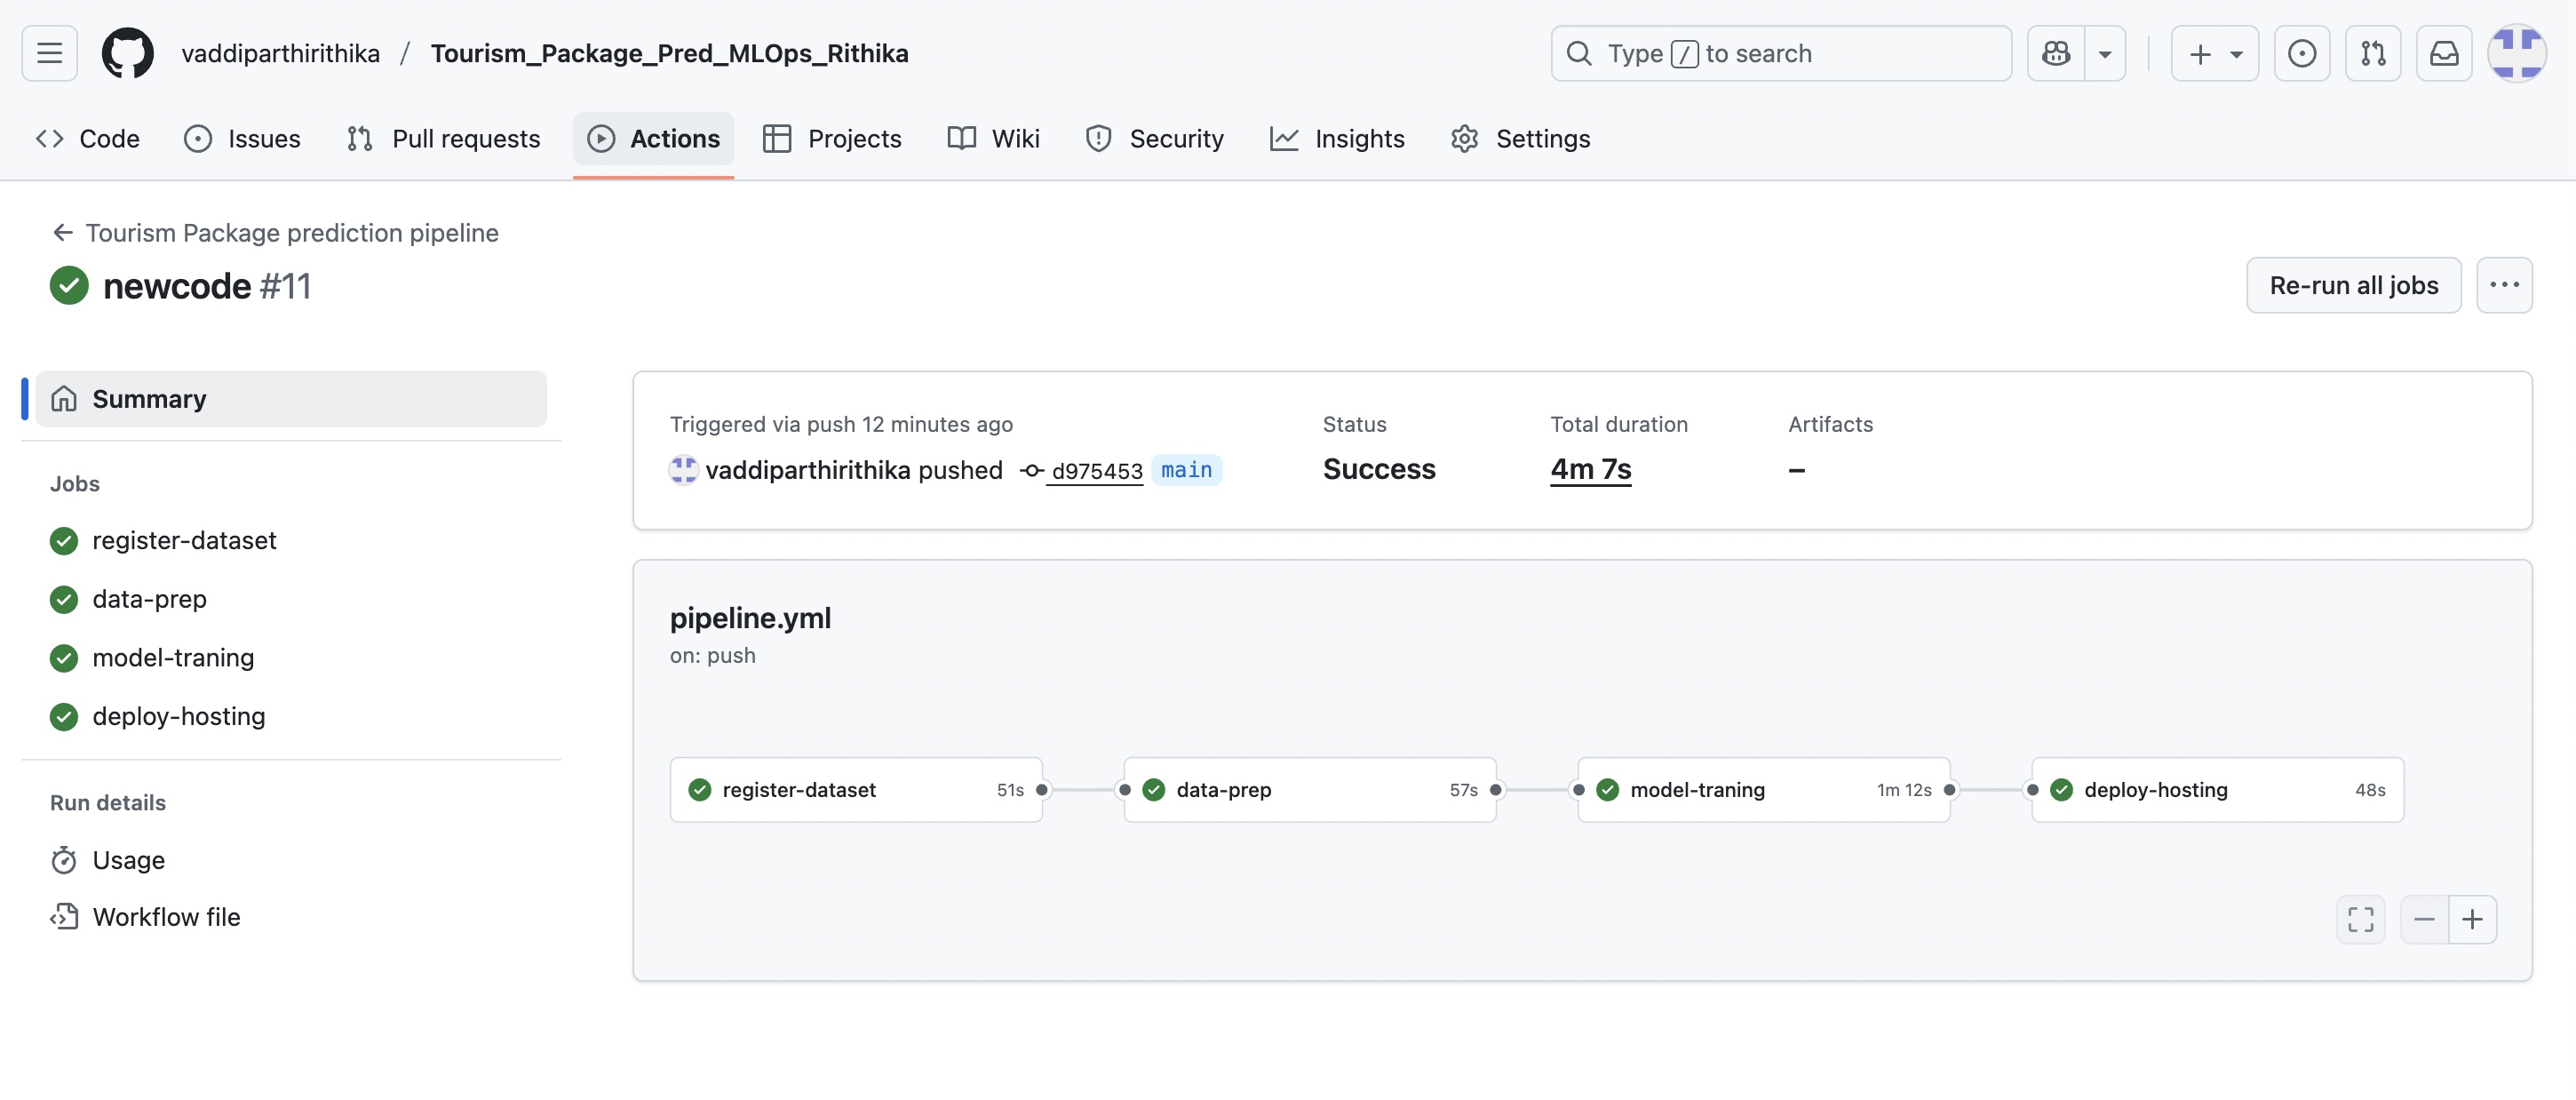

4. Streamlit App


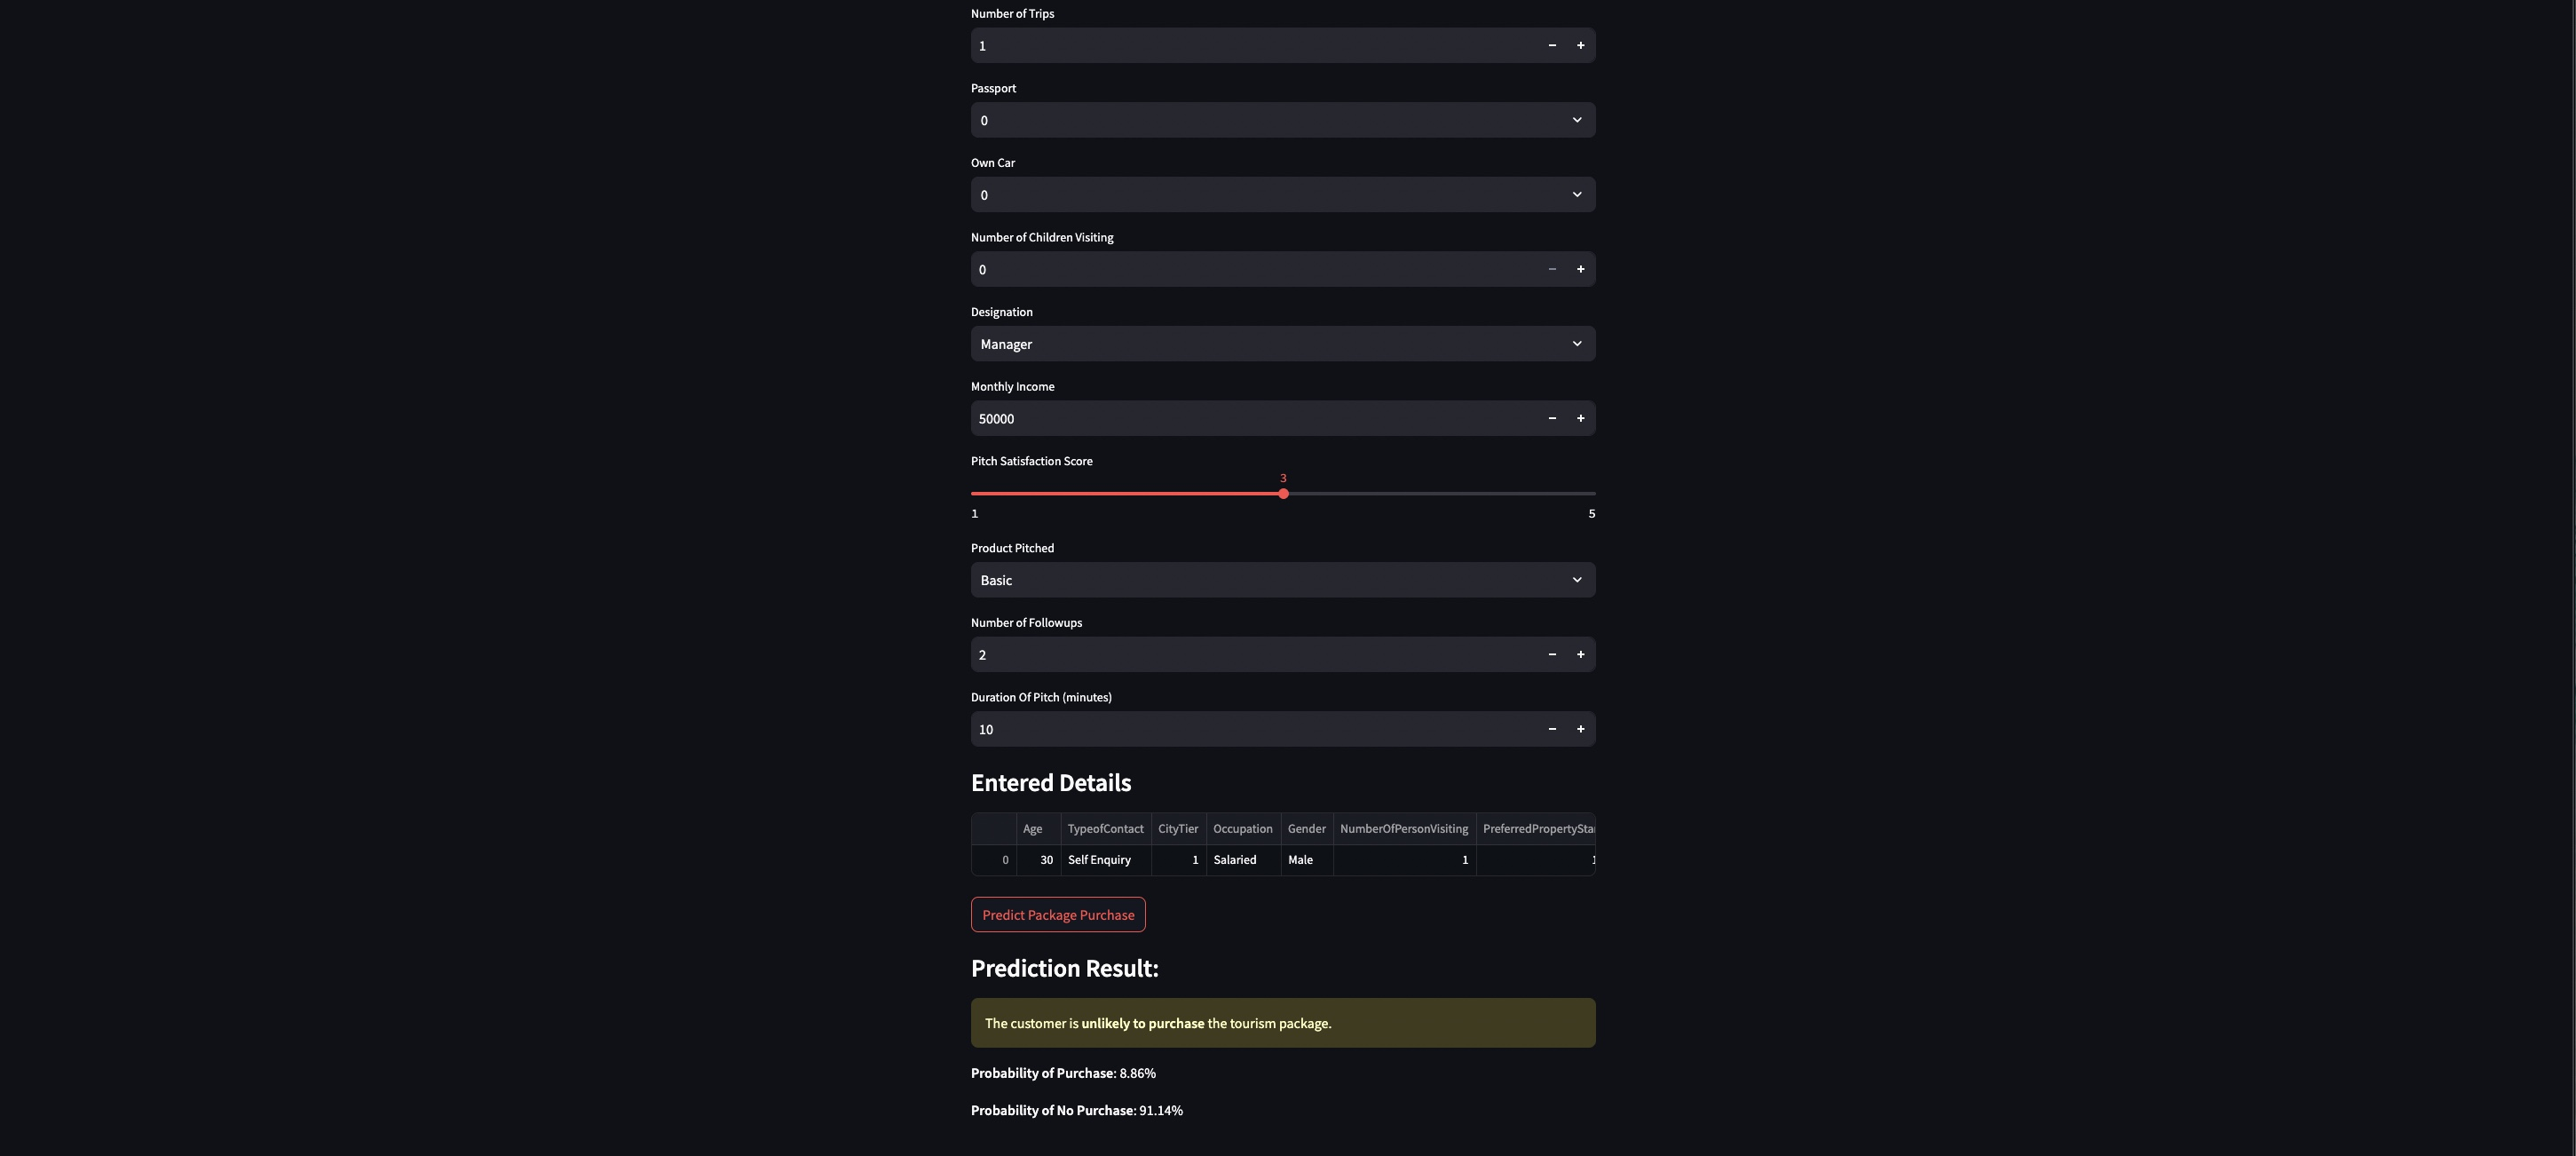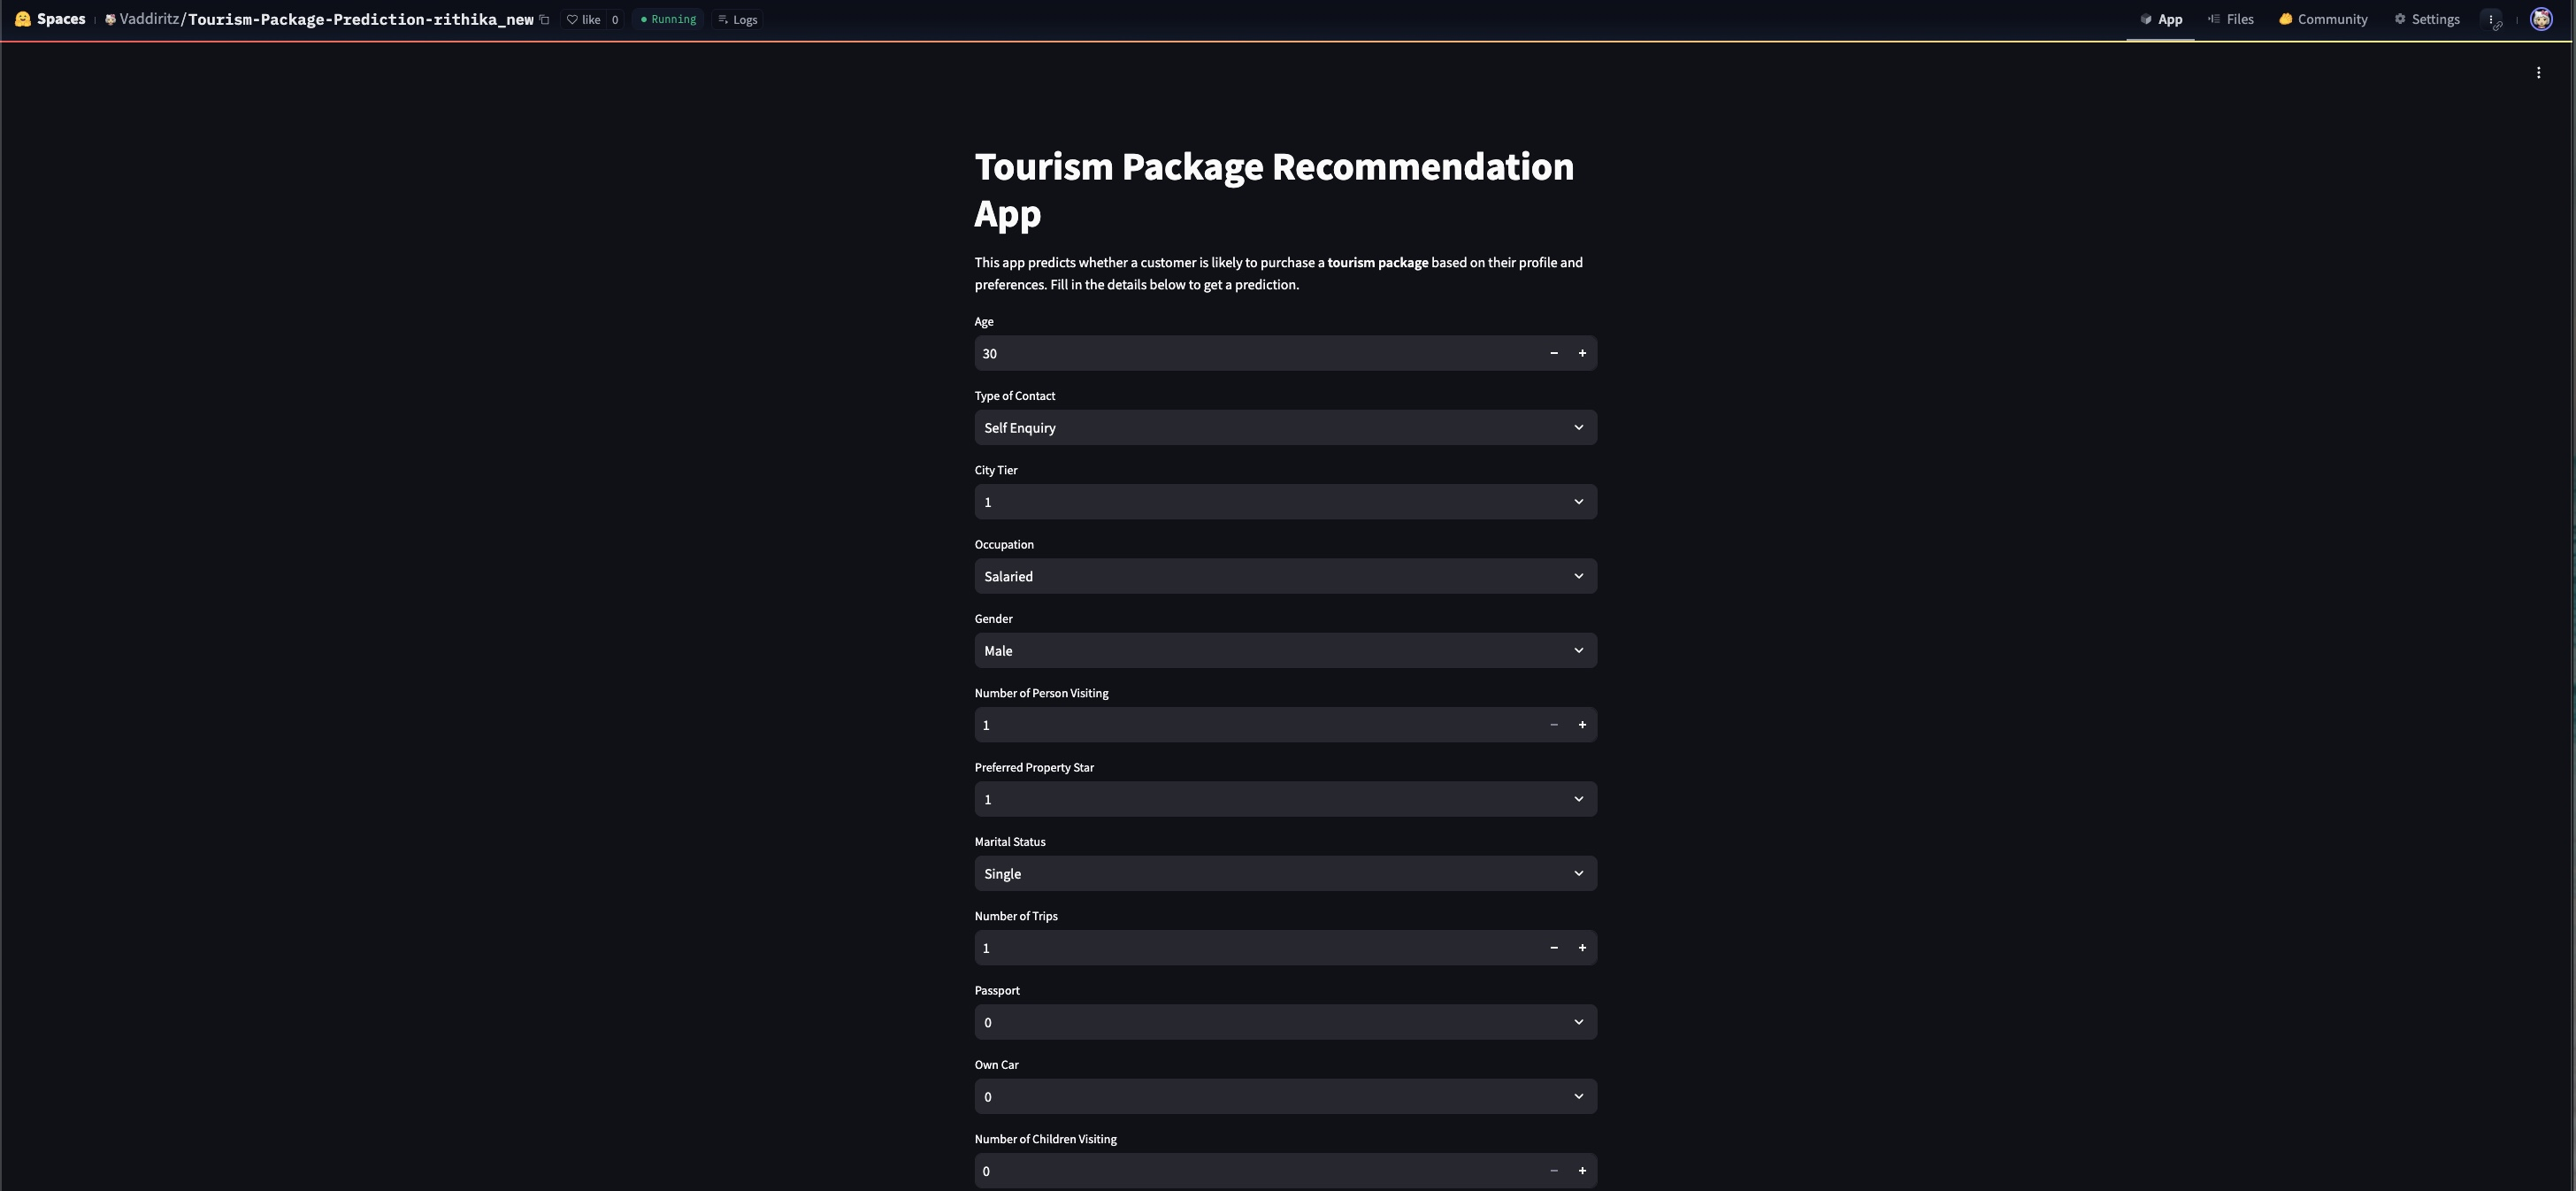

5. Git folder structure

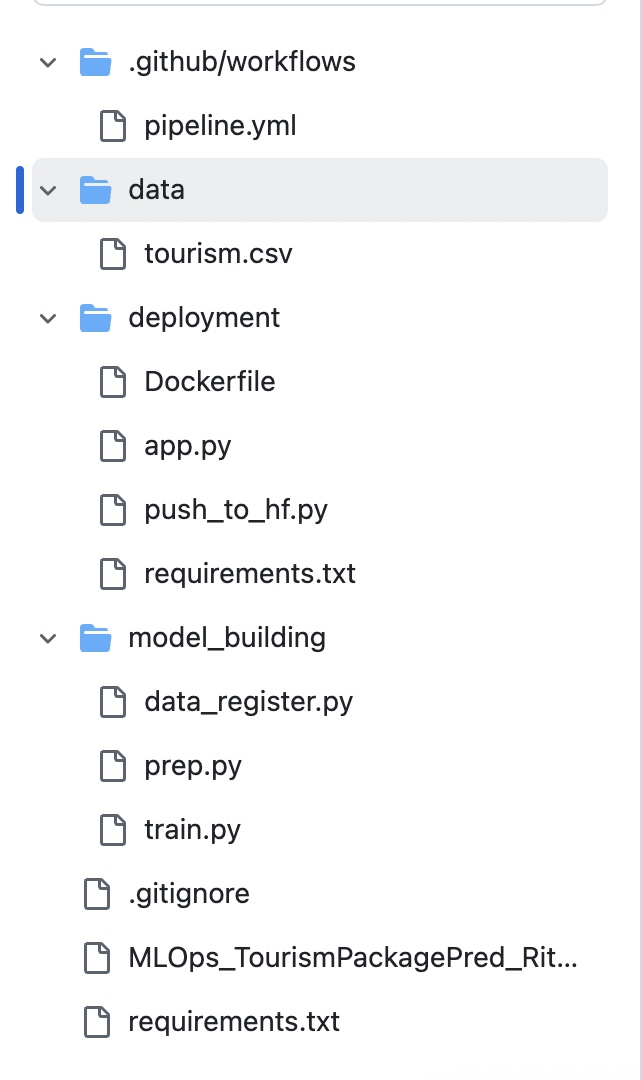

6. ML flow screenshot

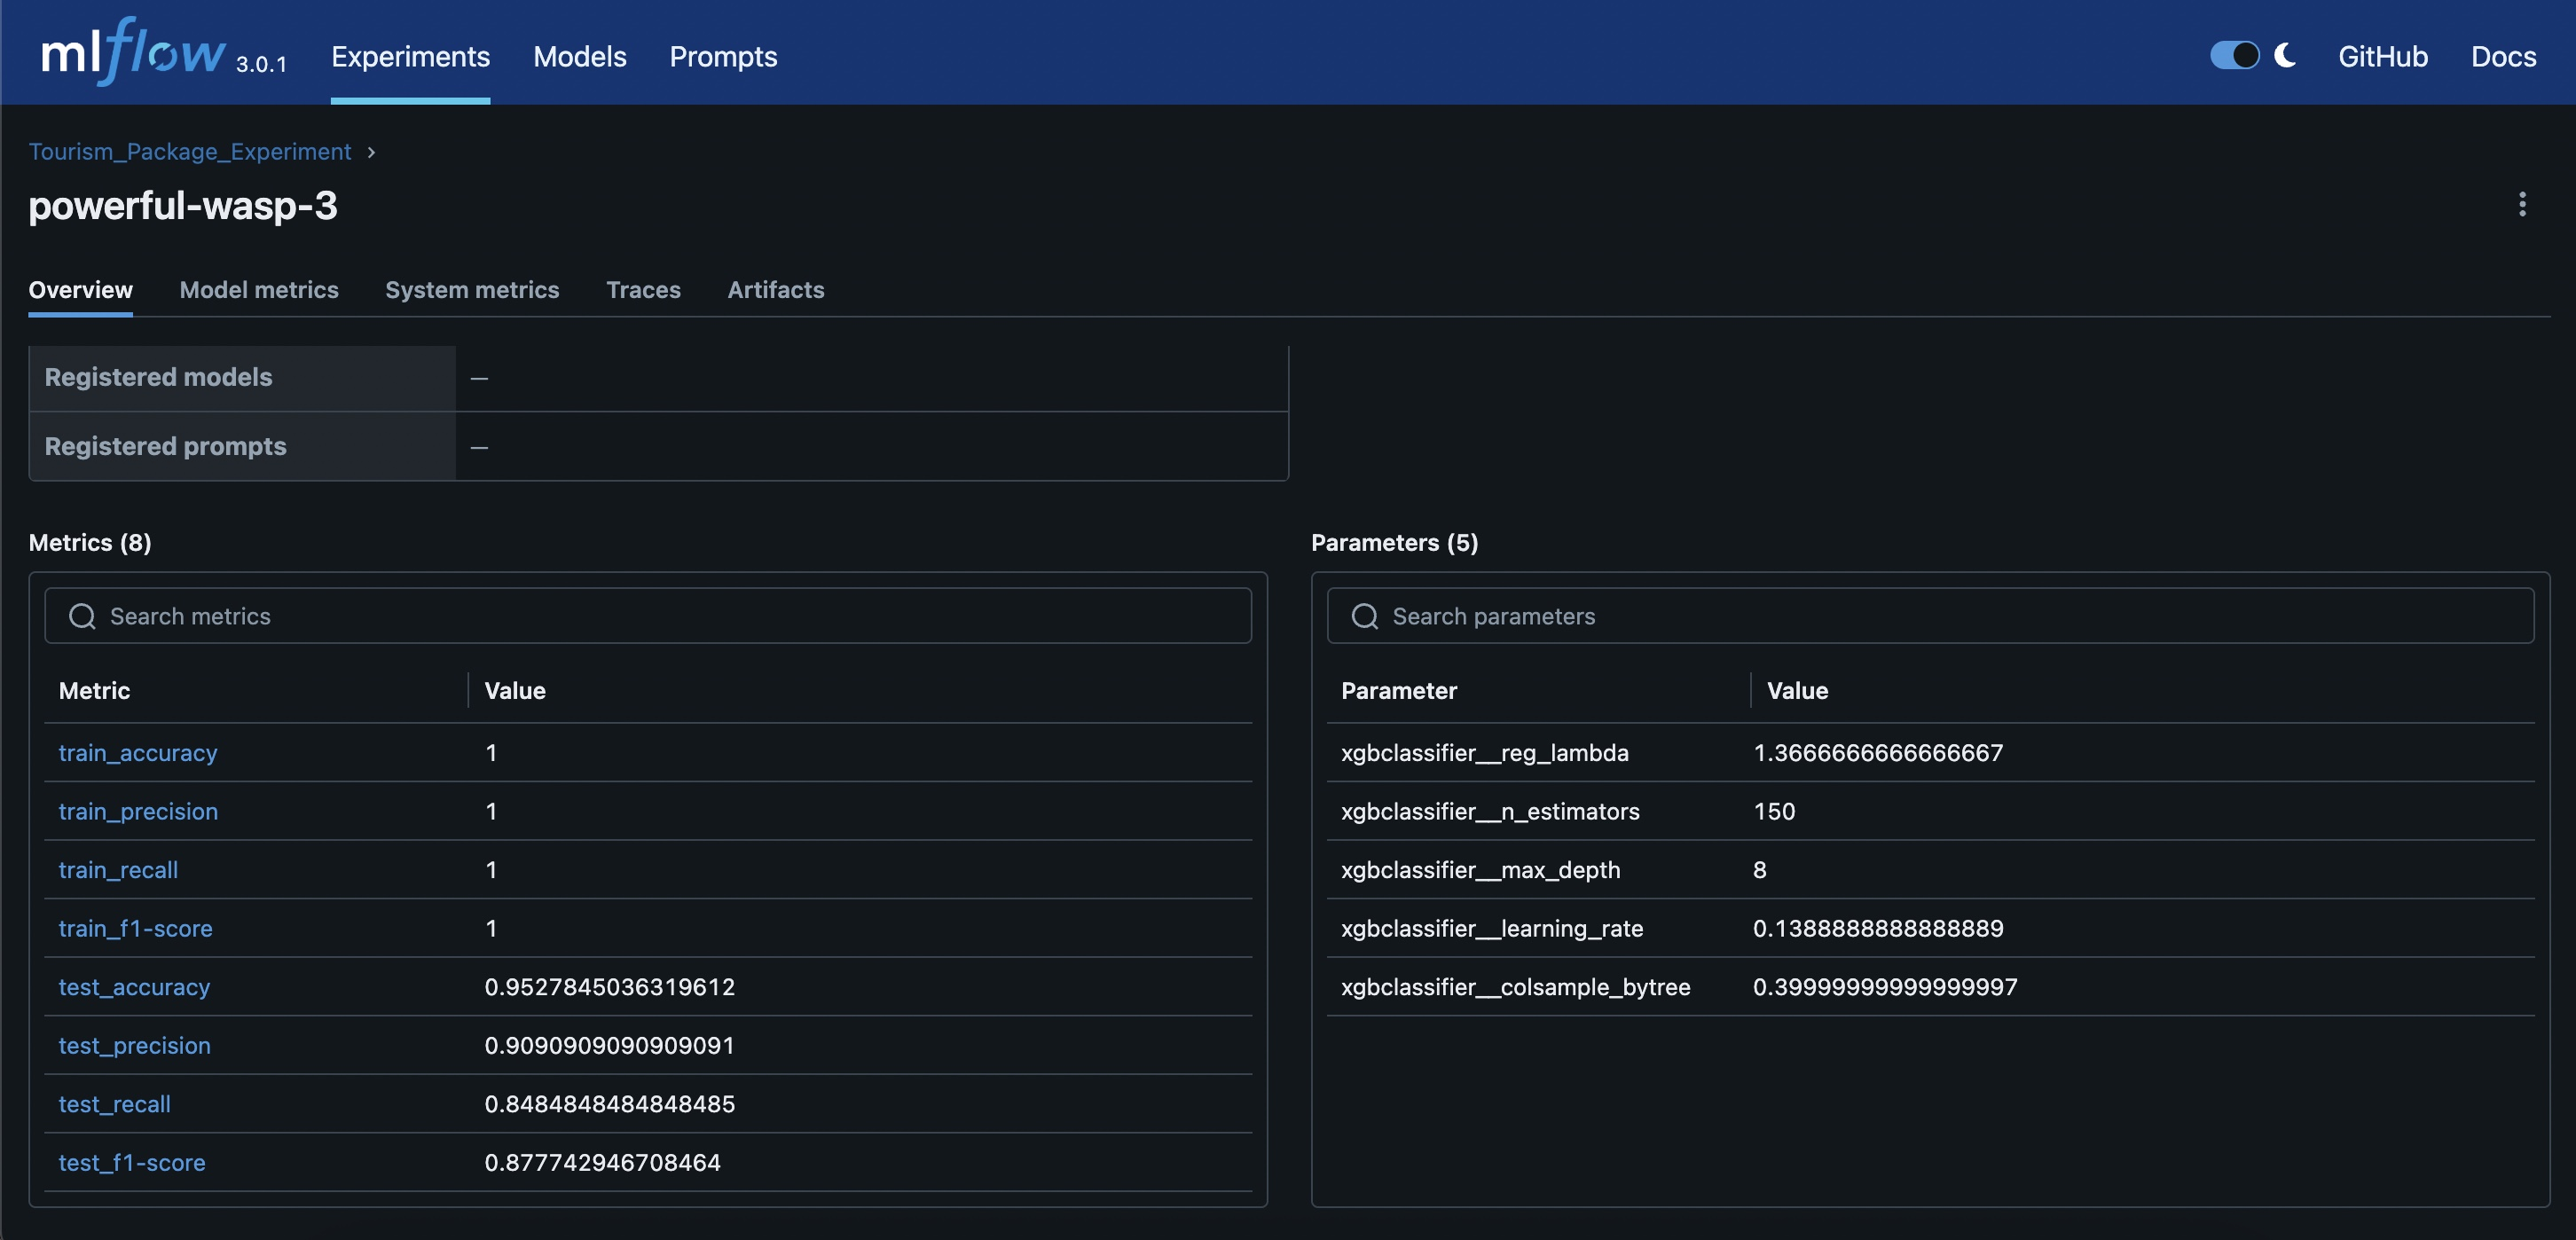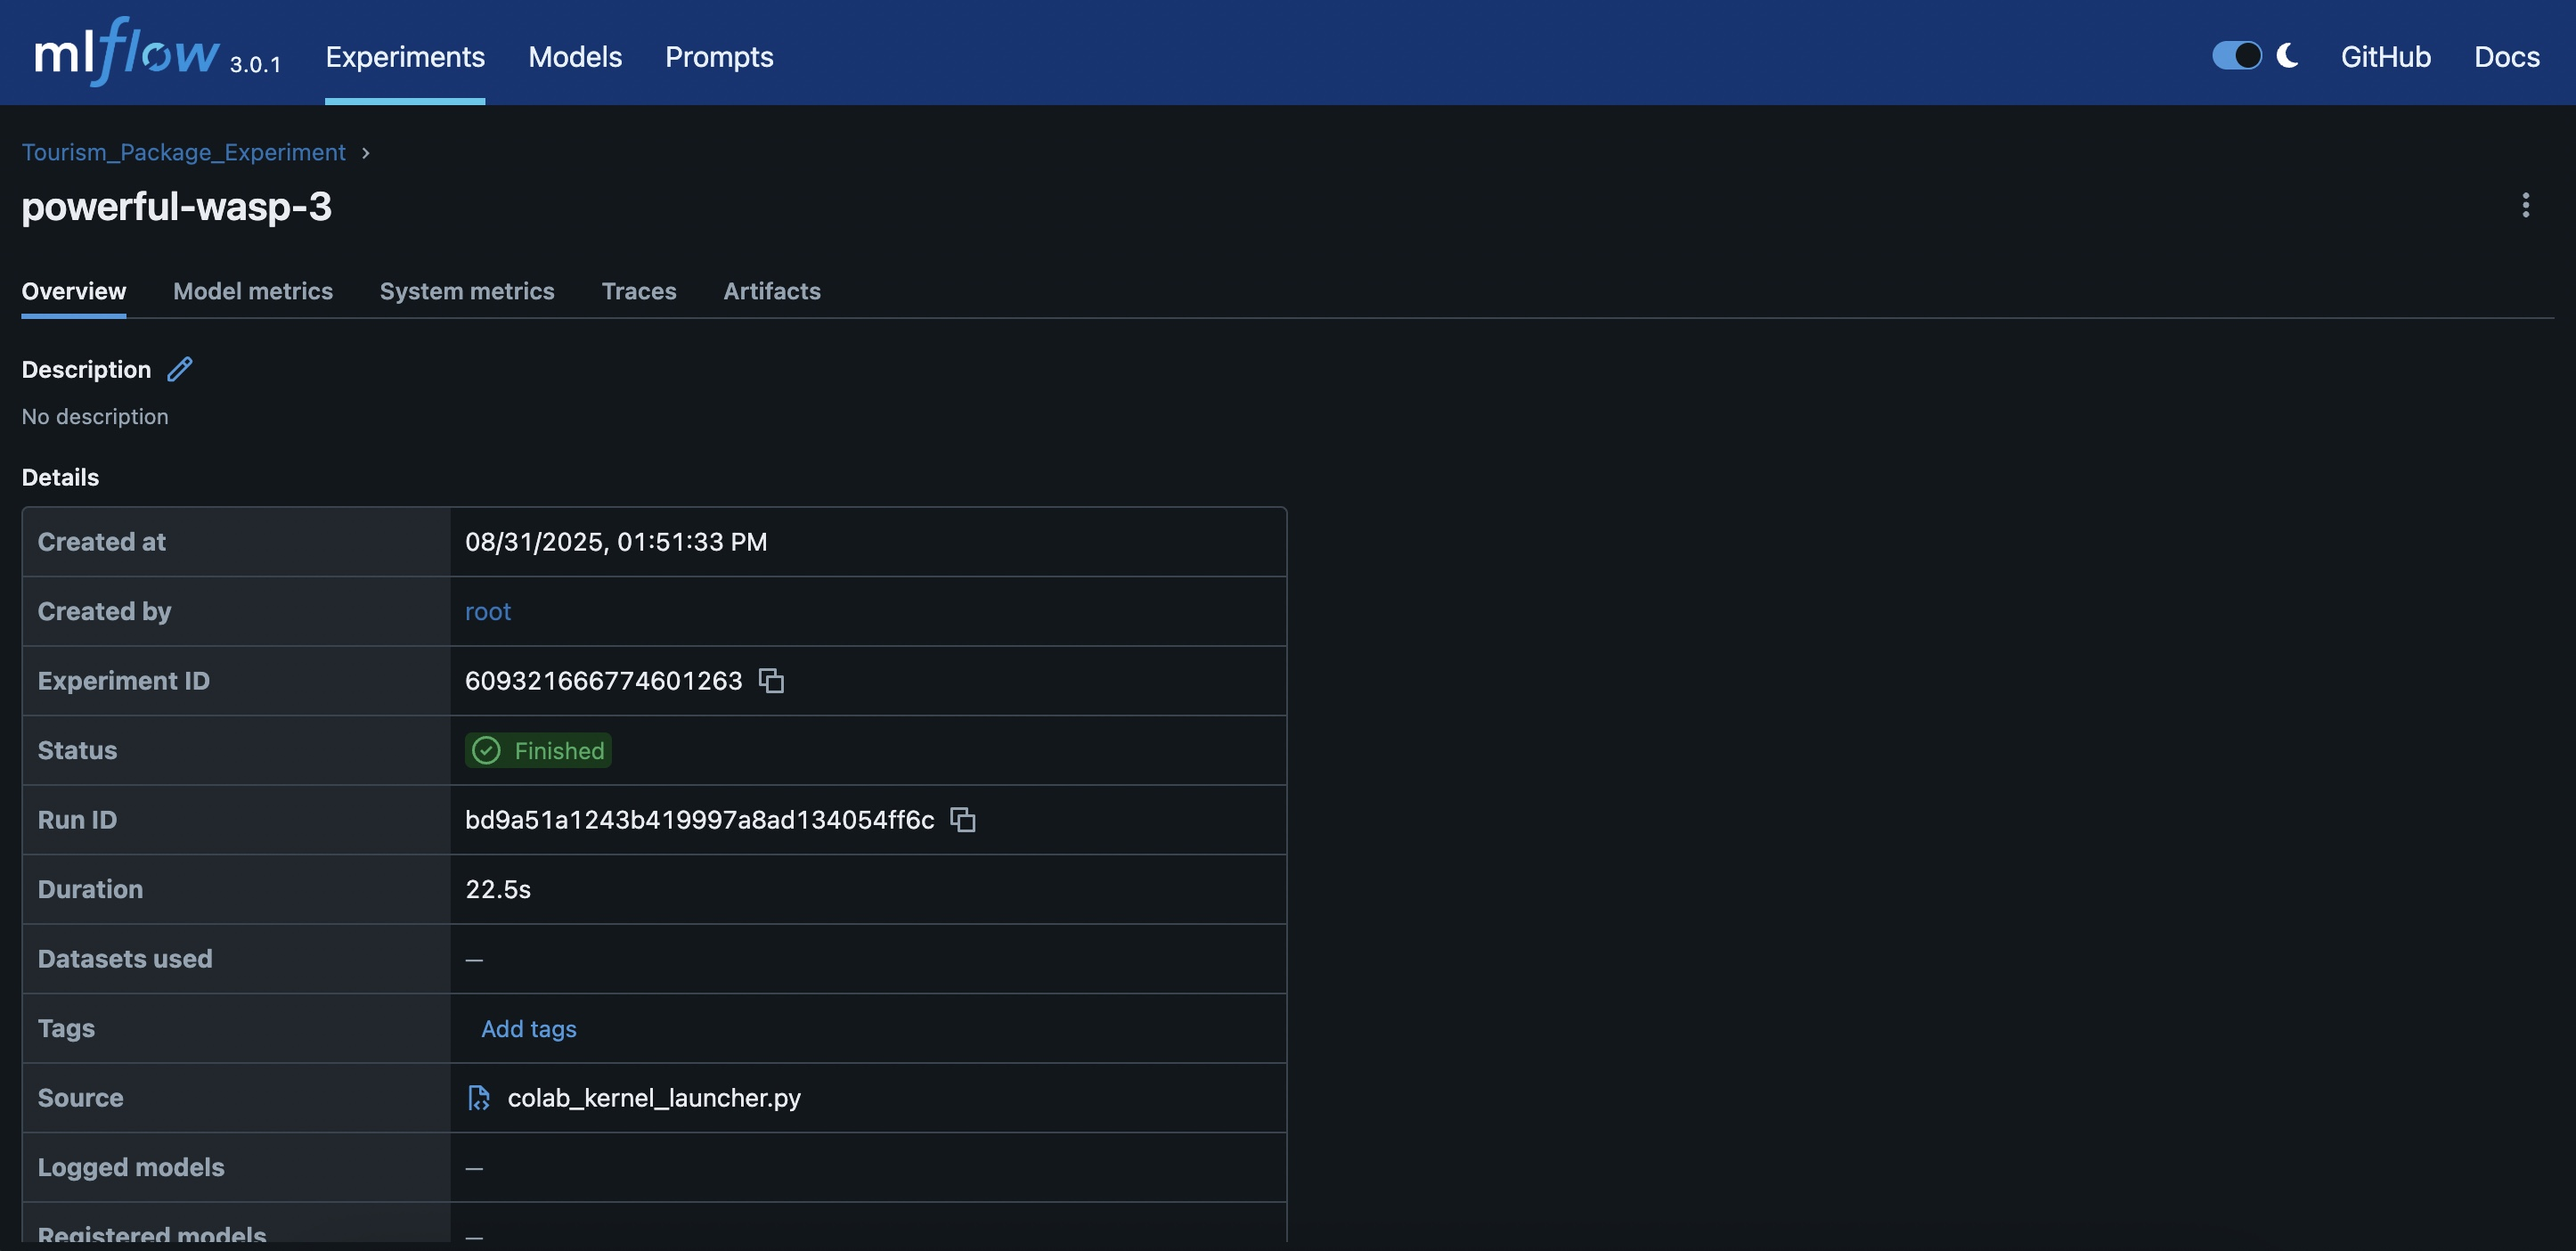